# Clustering Data

In [1]:
import numpy as np
from sklearn.datasets.samples_generator import make_blobs
from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.manifold import Isomap
from sklearn import datasets
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_extraction.text import TfidfVectorizer
from matplotlib import pyplot as plt
import matplotlib as mpl
from hdf5manager import hdf5manager as h5
from pandas import pandas as pd
from pandas import DataFrame
from skimage.measure import label, regionprops
import scipy
import scipy.ndimage.filters as filters
import scipy.ndimage as ndimage
from scipy.ndimage.filters import gaussian_filter, convolve
from scipy.ndimage.morphology import generate_binary_structure, binary_erosion
from scipy.ndimage.filters import maximum_filter
from scipy.stats import multivariate_normal as mvn
from scipy.spatial.distance import cdist
from skimage.morphology import disk, watershed
from skimage.morphology import erosion, dilation, opening, closing
from opticFlow import opticFlow as of
import colorsys
import wholeBrain as wb
from waveletAnalysis import waveletAnalysis as wave
import cv2
import os
import seaborn as sns
from time import time

Error importing slackNotify.py
	 ERROR :  No module named 'slacker'


## Set up Data & Pairplot

In [3]:
path = '/Users/jcrndm/Documents/'
file = '170721_07_c2_gridOpticFlow_metrics.csv'

tsv_output_file = path + file
data = pd.DataFrame.from_csv(tsv_output_file)

# print(data.head())

/Users/jcrndm/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning: from_csv is deprecated. Please use read_csv(...) instead. Note that some of the default arguments are different, so please refer to the documentation for from_csv when changing your function calls
  """


In [4]:
data = data.astype('float16')
data['classification'] = np.zeros(len(data))
data['classification'].iloc[data.loc[(data['mov.eventrest'] == 0.0) & (data['brain.eventrest'] == 1.0)].index] = 0
data['classification'].iloc[data.loc[(data['mov.eventrest'] == 0.0) & (data['brain.eventrest'] == 0.0)].index] = 1
data['classification'].iloc[data.loc[(data['mov.eventrest'] == 1.0) & (data['brain.eventrest'] == 1.0)].index] = 2
data['classification'].iloc[data.loc[(data['mov.eventrest'] == 1.0) & (data['brain.eventrest'] == 0.0)].index] = 3

/Users/jcrndm/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


/Users/jcrndm/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:488: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/Users/jcrndm/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


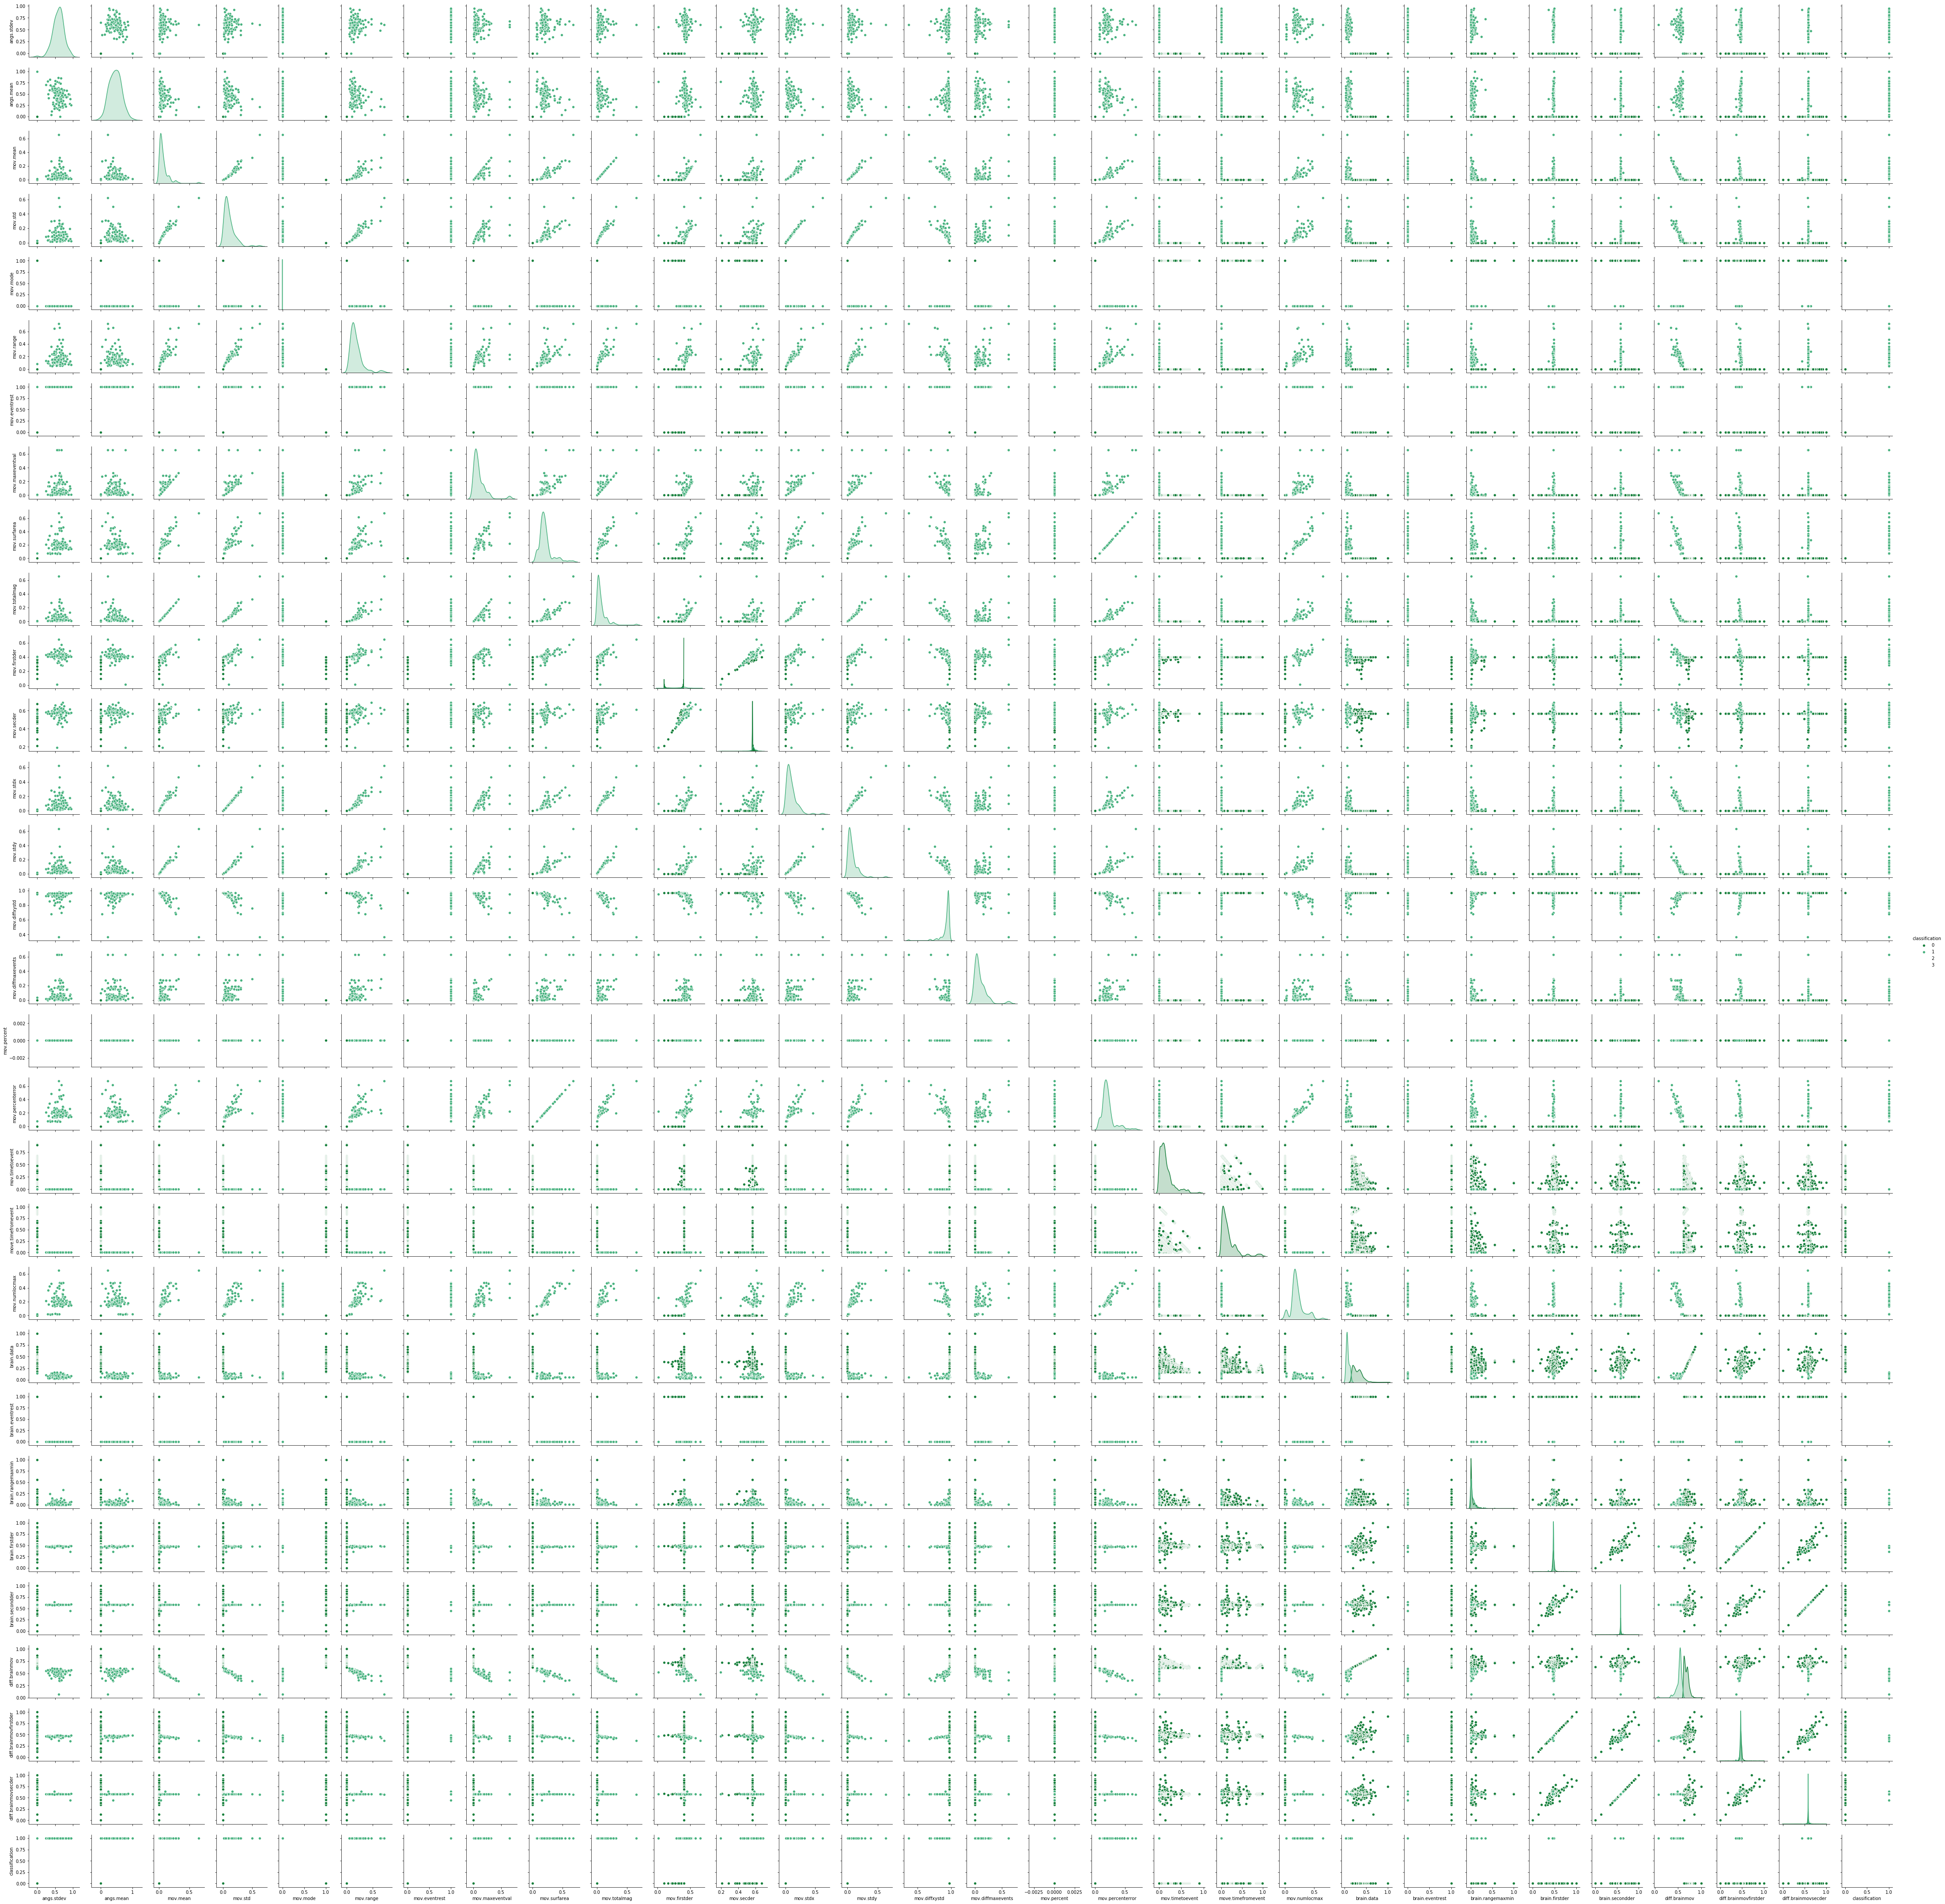

In [5]:
%matplotlib inline

col_list = list(data)

data -= data.min()
data /= data.max()
data = data.fillna(value=0)

sns.pairplot(data, 
             diag_kind="kde", height = 2, 
             markers=["o", "o", "o", "o"], 
             hue_order = [0, 1, 2, 3], hue='classification', palette = "BuGn_r")

plt.savefig('/Users/jcrndm/Documents/metrics_pairplot.png')

In [ ]:
path = '/Users/jcrndm/Documents/'
file = '170721_07_c1_gridOpticFlow_metrics.csv'

tsv_output_file = path + file
data = pd.DataFrame.from_csv(tsv_output_file)

'''
In PCA you are maximizing the length of the vector to each of the points from the center point
of the data (mean value of each of the two variables you are dealing with), at the same time, 
MINIMIZING the distance from each point to the line that you drew.

Maximizing variance & Orthogonalization
'''

sklearn_pca = PCA(n_components = 26)
Y_sklearn = sklearn_pca.fit_transform(data)
kmeans = KMeans(n_clusters=3, max_iter=600, algorithm = 'auto')
fitted = kmeans.fit(data)
prediction = kmeans.predict(data)

plt.figure(figsize = (10,8))
def plot_kmeans(kmeans, X, n_clusters=2, rseed=0, ax=None):
    labels = kmeans.fit_predict(X)

    # plot the input data
    ax = ax or plt.gca()
    ax.axis('equal')
    ax.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis', zorder=2)

    # plot the representation of the KMeans model
    centers = kmeans.cluster_centers_
    radii = [cdist(X[labels == i], [center]).max()
             for i, center in enumerate(centers)]
    for c, r in zip(centers, radii):
        ax.add_patch(plt.Circle(c, r, fc='#CCCCCC', lw=3, alpha=0.5, zorder=1))
    return labels
        
indices = plot_kmeans(kmeans, Y_sklearn[:,4:6])

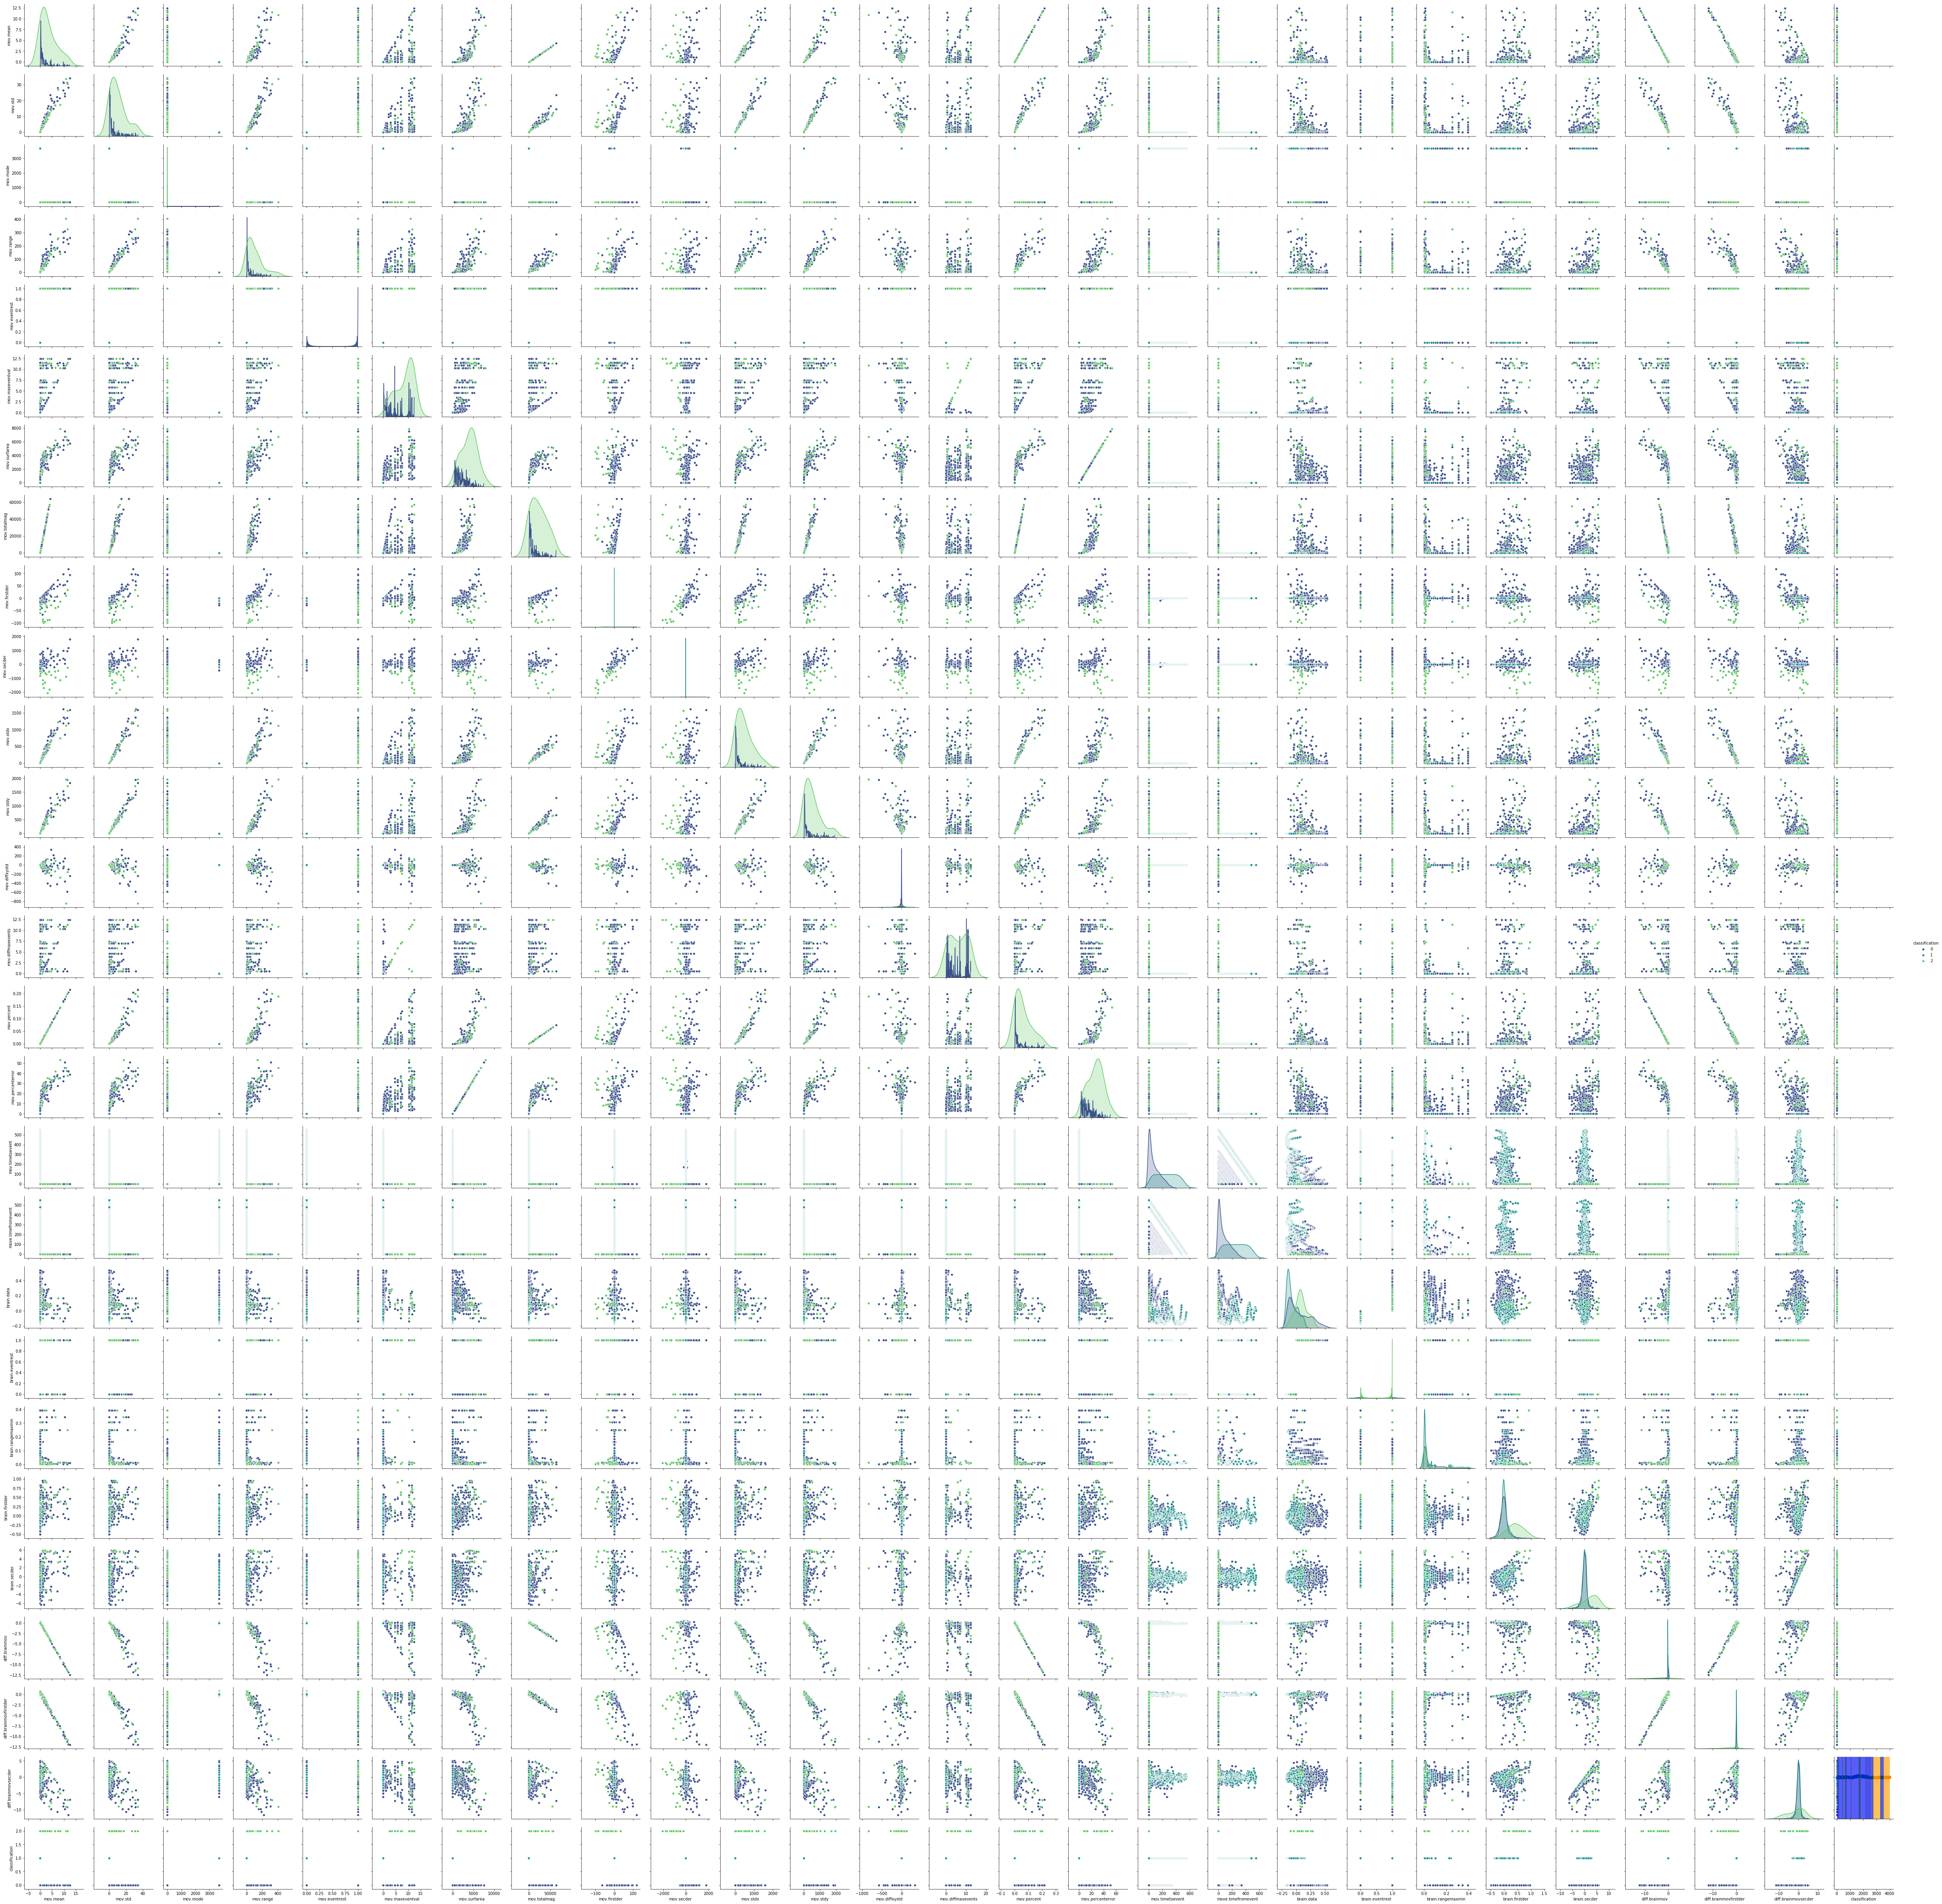

In [9]:
data_new = pd.DataFrame()
data_new = data.copy()
data_new = data_new.astype('float16')
indices = indices.astype('int')
data_new['classification'] = indices
# print("data_new : ", data_new["classification"])
# Both temporal and spatial metrics visualize  
sns.pairplot(data_new, diag_kind="kde", markers=["o", "o", "o"], 
             hue_order = [0, 1, 2], hue='classification', 
             palette = 'viridis')
plt.savefig('/Users/jcrndm/Documents/metrics_pairplot.png')

plt.scatter(np.array(np.where(indices==0)[0]), data.loc[np.where(indices==0)[0], "brain.data"])
plt.scatter(np.array(np.where(indices==1)[0]), data.loc[np.where(indices==1)[0], "brain.data"])
plt.scatter(np.array(np.where(indices==2)[0]), data.loc[np.where(indices==2)[0], "brain.data"])

for i in range(len(indices)):
    if (indices[i] == 0):
        plt.axvline(x = i, linewidth = 1, color = 'blue', alpha = 0.03)
    elif (indices[i] == 1):
        plt.axvline(x = i, linewidth = 1, color = 'orange', alpha = 0.03)
    elif (indices[i] == 2):
        plt.axvline(x = i, linewidth = 1, color = 'green')


## t-SNE Clustering

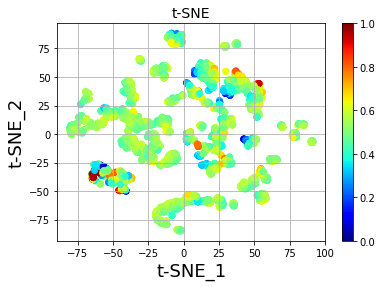

In [6]:
list_of_columns = ["mov.mean", "mov.std", "mov.mode", "mov.range", "mov.eventrest","mov.maxeventval", "mov.surfarea", 
                   "mov.totalmag", "mov.firstder", "mov.secder", "mov.timetoevent", "move.timefromevent", "brain.data", 
                   "brain.eventrest", "brain.rangemaxmin", "brain.firstder", "brain.secder", "diff.brainmov", 
                   "diff.brainmovfirstder", "diff.brainmovsecder"] 

data2 = data[list_of_columns].fillna(value=0).copy()
data2 = data2.replace([np.inf, -np.inf], 10**3,)
# print(np.sum(np.isinf(data2)))

data2 -= data2.min()
data2 /= data2.max()
tsne = TSNE(n_components=2, random_state=42)
X_reduced_tsne = tsne.fit_transform(data2.values)

plt.title('t-SNE', fontsize=14)
plt.scatter(X_reduced_tsne[:, 0], X_reduced_tsne[:, 1], c=data2['brain.secder'], cmap='jet')
plt.xlabel("t-SNE_1", fontsize=18)
plt.ylabel("t-SNE_2", fontsize=18)
plt.grid(True)

# save_fig("other_dim_reduction_plot")
plt.colorbar()
plt.show()

## Isomap Clustering

/Users/jcrndm/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


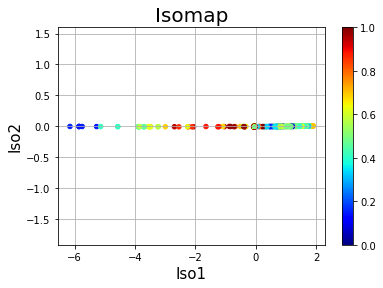

In [7]:
data = data.astype('float16')
data['classification'] = np.zeros(len(data))
data['classification'].iloc[data.loc[(data['mov.eventrest'] == 0.0) & (data['brain.eventrest'] == 1.0)].index] = 0
data['classification'].iloc[data.loc[(data['mov.eventrest'] == 0.0) & (data['brain.eventrest'] == 0.0)].index] = 1
data['classification'].iloc[data.loc[(data['mov.eventrest'] == 1.0) & (data['brain.eventrest'] == 1.0)].index] = 2
data['classification'].iloc[data.loc[(data['mov.eventrest'] == 1.0) & (data['brain.eventrest'] == 0.0)].index] = 3

list_of_columns = ["mov.mean", "mov.std", "mov.mode", "mov.range", "mov.eventrest","mov.maxeventval", "mov.surfarea", 
                   "mov.totalmag", "mov.firstder", "mov.secder", "mov.timetoevent", "move.timefromevent", "brain.data", 
                   "brain.eventrest", "brain.rangemaxmin", "brain.firstder", "brain.secder", "diff.brainmov", 
                   "diff.brainmovfirstder", "diff.brainmovsecder"] 

data2 = data[list_of_columns].fillna(value=0).copy()
data2 = data2.replace([np.inf, -np.inf], 10**3,)
# print(np.sum(np.isinf(data2)))

data2 -= data2.min()
data2 /= data2.max()
isomap = Isomap(n_components=2)
X_reduced_isomap = isomap.fit_transform(data2.values)

# embedding = Isomap(n_components=2)
# X_transformed = embedding.fit_transform(data[:100])
# print(X_transformed.shape)

plt.title('Isomap', fontsize=20)
plt.scatter(X_reduced_isomap[:, 0], X_reduced_isomap[:, 1],s=data['classification']*10, c=data2['brain.secder'], cmap='jet')
plt.xlabel("Iso1", fontsize=15)
plt.ylabel("Iso2", fontsize=15)
plt.grid(True)

plt.colorbar()
plt.show()